Mounting my Drive

In [ ]:
from google.colab import drive

drive.mount("./drive")

Mounted at ./drive


# **Installing Dependencies**


In [ ]:
# For using RoBERTA
!pip install transformers -q

     |████████████████████████████████| 5.8 MB 25.8 MB/s 
     |████████████████████████████████| 182 kB 78.8 MB/s 
     |████████████████████████████████| 7.6 MB 68.6 MB/s 


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install tensorflow-text==2.9.0 -q

     |████████████████████████████████| 4.6 MB 31.7 MB/s 


In [ ]:
# For using the AdamW optimizer
!pip install tf-models-official==2.9.2 -q

     |████████████████████████████████| 2.1 MB 30.3 MB/s 
     |████████████████████████████████| 1.1 MB 62.0 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 662 kB 63.6 MB/s 
     |████████████████████████████████| 352 kB 76.5 MB/s 
     |████████████████████████████████| 238 kB 52.5 MB/s 
     |████████████████████████████████| 118 kB 60.8 MB/s 
     |████████████████████████████████| 1.3 MB 60.2 MB/s 


In [ ]:
# For plotting accuracy live during training
!pip install livelossplot -q

# **Loading Data**

Download the data from Google Drive

In [ ]:
!gdown 1KZd_RVoOuOKb5YVhZyqOHbXoOUhr1WSE

Downloading...
From: https://drive.google.com/uc?id=1KZd_RVoOuOKb5YVhZyqOHbXoOUhr1WSE
To: /content/Movie_Reviews.csv
100% 66.2M/66.2M [00:01<00:00, 35.0MB/s]


Read the downloaded csv file

In [ ]:
import pandas as pd

data = pd.read_csv("./Movie_Reviews.csv")
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
reviews = data['review']
reviews

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [ ]:
sentiments = data['sentiment']
sentiments

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

Convert the sentiments to integer labels

In [ ]:
to_label_map = {
    "negative": 0,
    "positive": 1
}
labels = sentiments.apply(
    lambda sentiment: to_label_map[sentiment],
)
labels.name = "labels"
labels

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: labels, Length: 50000, dtype: int64

# **Data Preprocessing**

Showing a review sample to see how the data looks


In [ ]:
reviews[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

Remove HTML tags

In [ ]:
from bs4 import BeautifulSoup

preprocessed_reviews = reviews.apply(
    lambda text: BeautifulSoup(text, "html.parser").get_text()
)
# Check if the tags were removed from the sample we showed earlier.
preprocessed_reviews[1]

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

Remove punctuation and special characters

In [ ]:
import string

def remove_punctuation(text: str) -> str:
    """ Removes punctiation characters from `text`. """
    # Create a dictionary that makes every punctation character to an empty string.
    punctuation_map = {
        ord(character): "" for character in string.punctuation
    }
    # Hyphens ('-') are replaced with a spaces rather than being removed,
    # because that may result in some words getting stuck together.
    # For example, "short-term" becomes "shortterm".
    punctuation_map[ord('-')] = ' ' 
    # Apply the map on the given string.
    return text.translate(punctuation_map)

preprocessed_reviews = preprocessed_reviews.apply(remove_punctuation)
preprocessed_reviews[1]

'A wonderful little production The filming technique is very unassuming  very old time BBC fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen  Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece A masterful production about one of the great masters of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwells murals decorating every surface are terribly well done'

Convert all characters to lowercase

In [ ]:
preprocessed_reviews = preprocessed_reviews.apply(lambda text: text.lower())
preprocessed_reviews[1]

'a wonderful little production the filming technique is very unassuming  very old time bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen  michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done'

Filter out the stop words for each review

In [ ]:
import nltk

# Download the required package.
nltk.download("stopwords")
# Convert the English stopwords list to a set for faster `in` checks.
english_stopwords = set(nltk.corpus.stopwords.words("english"))

def filter_out_stopwords(text: str) -> list:
    # Split the text into a list of words.
    words = text.split()
    return [ word for word in words if word not in english_stopwords ]

non_stopwords = preprocessed_reviews.apply(filter_out_stopwords)
non_stopwords[1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['wonderful',
 'little',
 'production',
 'filming',
 'technique',
 'unassuming',
 'old',
 'time',
 'bbc',
 'fashion',
 'gives',
 'comforting',
 'sometimes',
 'discomforting',
 'sense',
 'realism',
 'entire',
 'piece',
 'actors',
 'extremely',
 'well',
 'chosen',
 'michael',
 'sheen',
 'got',
 'polari',
 'voices',
 'pat',
 'truly',
 'see',
 'seamless',
 'editing',
 'guided',
 'references',
 'williams',
 'diary',
 'entries',
 'well',
 'worth',
 'watching',
 'terrificly',
 'written',
 'performed',
 'piece',
 'masterful',
 'production',
 'one',
 'great',
 'masters',
 'comedy',
 'life',
 'realism',
 'really',
 'comes',
 'home',
 'little',
 'things',
 'fantasy',
 'guard',
 'rather',
 'use',
 'traditional',
 'dream',
 'techniques',
 'remains',
 'solid',
 'disappears',
 'plays',
 'knowledge',
 'senses',
 'particularly',
 'scenes',
 'concerning',
 'orton',
 'halliwell',
 'sets',
 'particularly',
 'flat',
 'halliwells',
 'murals',
 'decorating',
 'every',
 'surface',
 'terribly',
 'well',
 'done

Lemmatize the words extracted above

In [ ]:
# Download the required packages.
nltk.download("wordnet")
nltk.download("omw-1.4")
lemmatizer = nltk.stem.WordNetLemmatizer()

# Lemmatize each word per for every review.
lemmatized_words = non_stopwords.apply(
    lambda words: [ lemmatizer.lemmatize(word) for word in words ]
)
lemmatized_words[1]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


['wonderful',
 'little',
 'production',
 'filming',
 'technique',
 'unassuming',
 'old',
 'time',
 'bbc',
 'fashion',
 'give',
 'comforting',
 'sometimes',
 'discomforting',
 'sense',
 'realism',
 'entire',
 'piece',
 'actor',
 'extremely',
 'well',
 'chosen',
 'michael',
 'sheen',
 'got',
 'polari',
 'voice',
 'pat',
 'truly',
 'see',
 'seamless',
 'editing',
 'guided',
 'reference',
 'williams',
 'diary',
 'entry',
 'well',
 'worth',
 'watching',
 'terrificly',
 'written',
 'performed',
 'piece',
 'masterful',
 'production',
 'one',
 'great',
 'master',
 'comedy',
 'life',
 'realism',
 'really',
 'come',
 'home',
 'little',
 'thing',
 'fantasy',
 'guard',
 'rather',
 'use',
 'traditional',
 'dream',
 'technique',
 'remains',
 'solid',
 'disappears',
 'play',
 'knowledge',
 'sens',
 'particularly',
 'scene',
 'concerning',
 'orton',
 'halliwell',
 'set',
 'particularly',
 'flat',
 'halliwells',
 'mural',
 'decorating',
 'every',
 'surface',
 'terribly',
 'well',
 'done']

Join the lemmatized words to form a sentence

In [ ]:
preprocessed_reviews = lemmatized_words.apply(
    # Join each word in the list to a single string separated by spaces.
    lambda words: ' '.join(words)
)
preprocessed_reviews[1]

'wonderful little production filming technique unassuming old time bbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwells mural decorating every surface terribly well done'

In [ ]:
# Rename it to distinguish it from the raw reviews.
preprocessed_reviews.name = "preprocessed_reviews"

# **Common Helpers**

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn.model_selection
from livelossplot import PlotLossesKeras

In [ ]:
def train_test_split(data, labels):
    """
    Randomizes and splits the the given data into
    two datasets, 80% training and 20% test.

    Returns the data as a tuple ordered as follows:
    train, test, train_labels, test_labels
    """
    return sklearn.model_selection.train_test_split(
        data,
        labels,
        test_size=0.2,
        # Specify the seed to get the same shuffling across different runs.
        # This is important for training across different runs to prevent
        # testing using data the model trained on previously.
        random_state=1
    )

# The training data forms 80% of the total data.
# We wants 10% of the total data to be used for validation,
# so we use 12.5% of the train data for validation.
# 12.5% x 80% = 10%
VALIDATION_SPLIT = 0.125

In [ ]:
def get_predictions(output):
    """
    Returns the labels predicted by the model.

    Parameters:
    -----------
    output: The output returned from `model.predict()`.
    """
    # Values greater than 0.5 are assigned the label 1;
    # otherwise, they are assigned the label 0.
    return np.where(output > 0.5, 1, 0).flatten()

In [ ]:
def get_confusion_matrix(labels, predictions) -> pd.DataFrame:
    """
    Returns the confusion matrix of a model as a DataFrame.
    
    Parameters:
    -----------
    labels: The true labels.
    predictions: The labels predicted by the model.
    """
    matrix = tf.math.confusion_matrix(
        labels=labels,
        predictions=predictions,
        num_classes=2,
    )
    # Replace the indices of the row and column with the class names.
    label_names = ['negative', 'positive']
    return pd.DataFrame(matrix.numpy(),
                        columns=label_names,
                        index=label_names)

In [ ]:
def compute_metrics(confusion_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Returns the accuracy, precision, recall, specificity, and F-score.
    
    Parameters:
    -----------
    confusion_matrix: The confusion matrix of the model.
    """
    true_positives = confusion_matrix.loc["positive"]["positive"]
    false_positives = confusion_matrix.loc["positive"]["negative"]

    true_negatives = confusion_matrix.loc["negative"]["negative"]
    false_negatives = confusion_matrix.loc["negative"]["positive"]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    # Add along each column, then add along the returned row.
    total = confusion_matrix.sum().sum()

    return pd.Series({
        "Accuracy": (true_positives + true_negatives) / total,
        "Precision": precision,
        "Recall": recall,
        "Specificity": true_negatives / (true_negatives + false_positives),
        "F-score": 2 * precision * recall / (precision + recall)
    })

# **BERT Model**

In [ ]:
import tensorflow_hub as hub
# This module is not used, but is needed for the
# Bert layers to load. Do not remove this import!
import tensorflow_text
from keras.layers import Dense, Input, Dropout

Define the model's architecture

In [ ]:
class BertClassifier(tf.keras.Model):
    def __init__(self, train_bert_layer: bool, hidden_layers, dropout: float):
        # The model receives a text input.
        input = Input(shape=(), dtype=tf.string, name="input")

        # Load the preprocessor layer from TensorflowHub for encoding text into tokens.
        preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
        output = hub.KerasLayer(preprocessor_url, name="preprocessor")(input)

        # Load the BERT encoder layer from TensorflowHub.
        encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
        output = hub.KerasLayer(encoder_url, trainable=train_bert_layer, name="encoder")(output)

        # Output shape is (batch_size, 768).
        output = output["pooled_output"]
        
        # Add the given hidden layers.
        for layer_size in hidden_layers:
            output = Dense(layer_size, activation="relu", name=f"dense-{layer_size}")(output)

        # Add a dropout layer with the given dropout chance.
        output = Dropout(dropout, name=f"dropout-{dropout}")(output)

        # Add the output layer with a single sigmoid unit.
        # Its value represents the label 0 if it's between 0 and 0.5;
        # otherwise, it represents the label 1 otherwise.
        output = Dense(1, activation="sigmoid", name="output")(output)
        super().__init__(input, output)

## Using Preprocessed Text

### Setup

In [ ]:
bert_model = BertClassifier(train_bert_layer=False,
                            hidden_layers=[512, 256, 128, 64, 32],
                            dropout=0.5)

In [ ]:
bert_model.summary()

In [ ]:
tf.keras.utils.plot_model(bert_model)

In [ ]:
train, test, train_labels, test_labels = train_test_split(
    preprocessed_reviews,
    labels
)

### Training

Split the data into 80% train/validation and 20% test

In [ ]:
train

Choose the batch size, optimizer, etc.

In [ ]:
from official.nlp import optimization  # to create AdamW optimizer
import numpy as np

epochs = 25
batch_size = 32

train_size = (1 - VALIDATION_SPLIT) * train.size
steps_per_epoch = int(np.ceil(train_size / batch_size))
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

optimizer = optimization.create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw"
)

bert_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)

Add callbacks to be performed after each epoch

In [ ]:
# Stop training early if, after 5 epochs, validation loss doesn't decrease.
stop_early = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Save the best weights so far after each epoch.
bert_checkpoint_path = "./drive/MyDrive/Checkpoints/bert1"
save_weights = tf.keras.callbacks.ModelCheckpoint(
    bert_checkpoint_path,
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Plot the accuracy and loss live during training.
callbacks = [stop_early, save_weights, PlotLossesKeras()]

Load previously-saved weights, if any.

In [ ]:
bert_model.load_weights(bert_checkpoint_path)

Start the actual training process

In [ ]:
bert_model.fit(
    train,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks
)

### Testing

In [ ]:
test

In [ ]:
bert_model.evaluate(test, test_labels)

In [ ]:
output = bert_model.predict(test)
output

In [ ]:
predictions = get_predictions(output)
predictions

In [ ]:
confusion_matrix = get_confusion_matrix(test_labels, predictions)
confusion_matrix

In [ ]:
compute_metrics(confusion_matrix)

## Using Raw Text

### Setup

In [ ]:
bert_raw_model = BertClassifier(train_bert_layer=False,
                                hidden_layers=[512, 256, 128, 64, 32],
                                dropout=0.5)

In [ ]:
bert_raw_model.summary()

In [ ]:
tf.keras.utils.plot_model(bert_raw_model)

In [ ]:
train, test, train_labels, test_labels = train_test_split(
    reviews,
    labels,
    test_size=0.2,
    # Specify the seed to get the same shuffling across different runs.
    # This is important for training across different runs to prevent
    # testing using data the model trained on previously.
    random_state=1
)

### Training

Split the data into 80% train/validation and 20% test

In [ ]:
train

Choose the batch size, optimizer, etc.

In [ ]:
from official.nlp import optimization  # to create AdamW optimizer
import numpy as np

epochs = 25
batch_size = 32
# The training data forms 80% of the total data.
# We wants 10% of the total data to be used for validation,
# so we use 12.5% of the train data for validation.
# 12.5% x 80% = 10%
validation_split = 0.125

train_size = (1 - VALIDATION_SPLIT) * train.size
steps_per_epoch = int(np.ceil(train_size / batch_size))
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

optimizer = optimization.create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw"
)

bert_raw_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)

Add callbacks to be performed after each epoch

In [ ]:
# Stop training early if, after 5 epochs, validation loss doesn't decrease.
stop_early = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Save the best weights so far after each epoch.
bert_checkpoint_path = "./drive/MyDrive/Checkpoints/bert2"
save_weights = tf.keras.callbacks.ModelCheckpoint(
    bert_checkpoint_path,
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Plot the accuracy and loss live during training.
callbacks = [stop_early, save_weights, PlotLossesKeras()]

Load previously-saved weights, if any.

In [ ]:
bert_raw_model.load_weights(bert_checkpoint_path)

Start the actual training process

In [ ]:
bert_raw_model.fit(
    train,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks
)

### Testing

In [ ]:
test

In [ ]:
bert_raw_model.evaluate(test, test_labels)

In [ ]:
output = bert_raw_model.predict(test)
output

In [ ]:
predictions = get_predictions(output)
predictions

In [ ]:
confusion_matrix = get_confusion_matrix(test_labels, predictions)
confusion_matrix

In [ ]:
compute_metrics(confusion_matrix)

# **RoBERTa Model**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
from keras.layers import Dense, Dropout, Input

Define the tokenizer for tokenizing reviews

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(texts):
    return dict(                    # - It is necessary to convert the output of the tokenizer
        tokenizer(                  #   to a dictionary to use it in model.fit().
            list(texts),            # - The tokenizer accepts a string or a list of string.
            padding='max_length',   # - Apply padding and truncation so that all text has
            truncation=True,        #   a length of `max_length`, which is 512 in this case.
            return_tensors='tf'     # - Return tensorflow tensors instead of pytorch.
        )
    )

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Define the model's architecture

In [ ]:
class RobertaModel(tf.keras.Model):

    def __init__(self, hidden_layers: list, dropout: float):
        inputs = [
            # The tokenizer outputs a dictionary with two keys,
            # input ids which contain the tokens, and attention masks for
            # determining if a token is a CLS or pad token.# We must name
            # the input layers with the same as the dictionary's keys to
            # be able to use the dictionary as input.
            Input(shape=(512,), dtype=tf.int32, name="input_ids"),
            Input(shape=(512,), dtype=tf.int32, name="attention_mask")
        ]
        output = TFRobertaModel.from_pretrained("roberta-base", name="roberta")(inputs)

        # Pooler output's shape is (batch size, 768).
        output = output.pooler_output

        # Pass the pooler's output to hidden layers.
        for layer in hidden_layers:
            output = Dense(layer, activation="relu", name=f"dense-{layer}")(output)
        
        # Add a dropout layer before the classifier to reduce overfitting.
        output = Dropout(dropout, name=f"dropout-{dropout}")(output)

        # Finally, a binary classifier layer using sigmoid activation.
        output = Dense(1, activation="sigmoid", name="output")(output)

        super().__init__(inputs=inputs, outputs=output)

## Using Preprocessed Text

### Setup

In [ ]:
roberta = RobertaModel(
    hidden_layers=[512, 256, 128, 64],
    dropout=0.5,
)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
roberta.summary()

Model: "roberta_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 roberta (TFRobertaModel)       TFBaseModelOutputWi  124645632   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                   

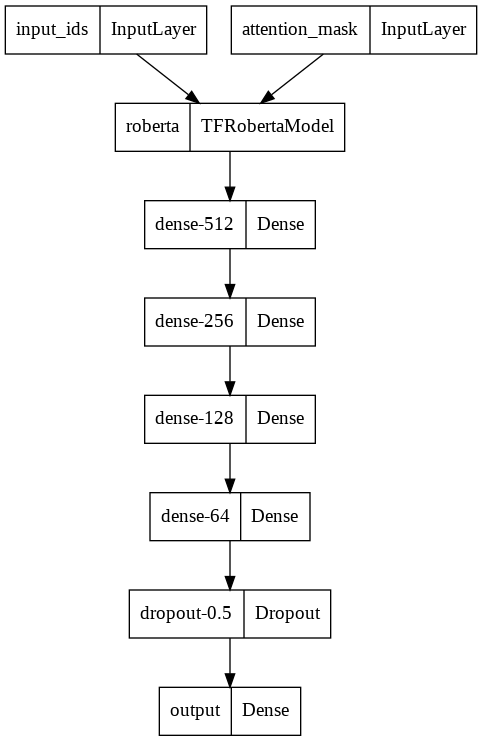

In [ ]:
tf.keras.utils.plot_model(roberta)

In [ ]:
train, test, train_labels, test_labels = train_test_split(
    preprocessed_reviews,
    labels
)

### Training

In [ ]:
tokenized_train = tokenize(train)

In [ ]:
tokenized_train

{'input_ids': <tf.Tensor: shape=(40000, 512), dtype=int32, numpy=
 array([[    0, 21928,  1118, ...,     1,     1,     1],
        [    0, 41995,  4735, ...,     1,     1,     1],
        [    0,  1344, 41678, ...,     1,     1,     1],
        ...,
        [    0, 13533, 41629, ...,     1,     1,     1],
        [    0, 42607,  3184, ...,     1,     1,     1],
        [    0,  8738,  2242, ...,     1,     1,     1]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(40000, 512), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
from keras.optimizers import Adam

roberta.compile(
    optimizer=Adam(
        learning_rate=1e-5,
        clipnorm=1.         # Clip the gradient of each weight so that its norm is no more than 1.
    ),                      # This help prevent large gradients, which ruins gradient descent.
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)

In [ ]:
# Stop training early if, after 3 epochs, validation loss doesn't decrease.
stop_early = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Save the best weights so far after each epoch.
roberta_checkpoint_path = "./drive/MyDrive/Checkpoints/roberta1"
save_weights = tf.keras.callbacks.ModelCheckpoint(
    roberta_checkpoint_path,
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Plot the accuracy and loss live during training.
callbacks = [stop_early, save_weights, PlotLossesKeras()]

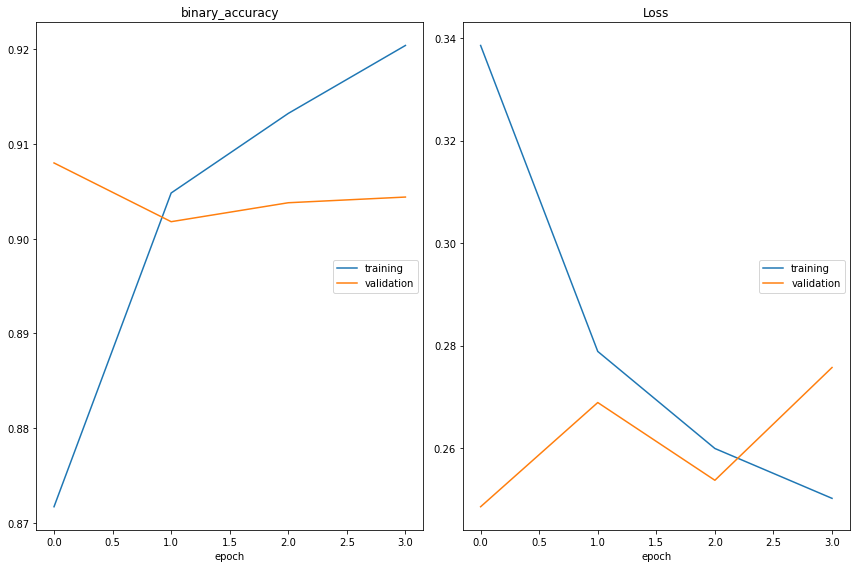

binary_accuracy
	training         	 (min:    0.872, max:    0.920, cur:    0.920)
	validation       	 (min:    0.902, max:    0.908, cur:    0.904)
Loss
	training         	 (min:    0.250, max:    0.339, cur:    0.250)
	validation       	 (min:    0.249, max:    0.276, cur:    0.276)
4375/4375 [==============================] - 4197s 959ms/step - loss: 0.2502 - binary_accuracy: 0.9204 - val_loss: 0.2757 - val_binary_accuracy: 0.9044


In [ ]:
roberta.fit(
    tokenized_train,
    train_labels,
    epochs=10,
    batch_size=8, # Use a batch size of 8 to avoid too much memory consumption.
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
)

### Testing

In [ ]:
tokenized_test = tokenize(test)

In [ ]:
tokenized_test

{'input_ids': <tf.Tensor: shape=(10000, 512), dtype=int32, numpy=
array([[    0, 18758,  6132, ...,     1,     1,     1],
       [    0, 26086,  2085, ...,     1,     1,     1],
       [    0,   523,  1459, ...,     1,     1,     1],
       ...,
       [    0,   179, 33591, ...,     1,     1,     1],
       [    0,  9244, 15072, ...,     1,     1,     1],
       [    0,  2678, 45851, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(10000, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
roberta.evaluate(tokenized_test, test_labels)

313/313 [==============================] - 386s 1s/step - loss: 0.2616 - binary_accuracy: 0.9044


[0.2615986168384552, 0.9043999910354614]

In [ ]:
output = roberta.predict(test)
output

313/313 [==============================] - 383s 1s/step


array([[0.06504678],
       [0.06593239],
       [0.06491838],
       ...,
       [0.3806119 ],
       [0.80887765],
       [0.06470577]], dtype=float32)

In [ ]:
predictions = get_predictions(output)
predictions

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
confusion_matrix = get_confusion_matrix(test_labels, predictions)
confusion_matrix

,negative,positive
negative,4571,473
positive,483,4473


In [ ]:
compute_metrics(confusion_matrix)

Accuracy       0.904400
Precision      0.902542
Recall         0.904367
Specificity    0.904432
F-score        0.903454
dtype: float64

## Using Raw Text

### Setup

In [ ]:
roberta_raw = RobertaModel(
    hidden_layers=[512, 256, 128, 64],
    dropout=0.5,
)

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
roberta_raw.summary()

Model: "roberta_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 roberta (TFRobertaModel)       TFBaseModelOutputWi  124645632   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                   

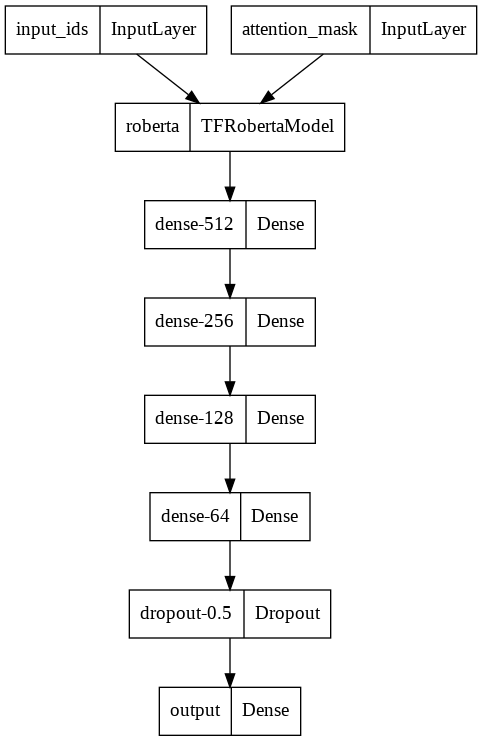

In [ ]:
tf.keras.utils.plot_model(roberta_raw)

In [ ]:
train, test, train_labels, test_labels = train_test_split(
    reviews,
    labels
)

### Training

In [ ]:
tokenized_train = tokenize(train)

In [ ]:
tokenized_train

In [ ]:
from keras.optimizers import Adam

roberta_raw.compile(
    optimizer=Adam(
        learning_rate=1e-5,
        clipnorm=1.         # Clip the gradient of each weight so that its norm is no more than 1.
    ),                      # This help prevent large gradients, which ruins gradient descent.
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)

In [ ]:
# Stop training early if, after 3 epochs, validation loss doesn't decrease.
stop_early = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Save the best weights so far after each epoch.
roberta_raw_checkpoint_path = "./drive/MyDrive/Checkpoints/roberta_raw"
save_weights = tf.keras.callbacks.ModelCheckpoint(
    roberta_raw_checkpoint_path,
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Plot the accuracy and loss live during training.
callbacks = [stop_early, save_weights, PlotLossesKeras()]

In [ ]:
roberta_raw.fit(
    tokenized_train,
    train_labels,
    epochs=10,
    batch_size=8, # Use a batch size of 8 to avoid too much memory consumption.
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
)

### Testing

Load previously-saved weights before testing

In [ ]:
roberta_raw.load_weights(roberta_raw_checkpoint_path)

In [ ]:
tokenized_test = tokenize(test)

In [ ]:
tokenized_test

{'input_ids': <tf.Tensor: shape=(10000, 512), dtype=int32, numpy=
 array([[    0,  3908,   440, ...,     1,     1,     1],
        [    0,   100,   802, ...,     1,     1,     1],
        [    0,  4688,  6281, ...,     1,     1,     1],
        ...,
        [    0,   970,    16, ...,     1,     1,     1],
        [    0,  1779,    20, ...,     1,     1,     1],
        [    0,  7516, 45851, ...,     1,     1,     1]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(10000, 512), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
roberta_raw.evaluate(tokenized_test, test_labels)

In [ ]:
output = roberta_raw.predict(test)
output

In [ ]:
predictions = get_predictions(output)
predictions

In [ ]:
confusion_matrix = get_confusion_matrix(test_labels, predictions)
confusion_matrix

In [ ]:
compute_metrics(confusion_matrix)

# **RNN Model**

In [ ]:
from keras import Sequential, layers

Generate the vocabulary from our train data

In [ ]:
def generate_vocabulary(texts):
    # Split each text by whitespaces, which generates the words.
    words = map(lambda text: text.split(), texts)
    # Generate a vocabulary for each review by generating a set
    # of words for each. This removes duplicate words.
    word_vocabularies = map(lambda words: set(words), words)
    # To find the total vocabulary, we find the union of all these sets.
    total_vocabulary = set.union(*word_vocabularies)
    # Convert to a numpy array to use with the RNN model.
    return np.array(list(total_vocabulary), dtype=str)

In [ ]:
class RNNClassifier(Sequential):
    def __init__(
        self,
        vocabulary,
        embedding_output_dim: int,
        lstm_units: int,
        sequence_length: int = 512,
        dropout: float = 0.0,
        recurrent_dropout: float = 0.0
    ):
        super().__init__([
            # The input needs to have a shape of (1,) because we need to
            # guarantee that there is exactly one string input per batch.
            layers.Input(shape=(1,), dtype=tf.string, name="input"),
            # Pass `None` to `standardize` because text preprocessing
            # is handled manually outside the model. This shows the
            # significance of preprocessing on the model's performance.
            layers.TextVectorization(
                vocabulary=vocabulary,
                standardize=None,
                # Each sequence is padded or truncated to the given length.
                output_sequence_length=sequence_length,
                name=f"text-vectorization-{sequence_length}"
            ),
            layers.Embedding(
                # `input_dim` takes the vocabulary size.
                input_dim=len(vocabulary),
                output_dim=embedding_output_dim,
                input_length=sequence_length,
                name="embedding"
            ),
            # Add a long-short-term memory layer
            layers.LSTM(
                units=lstm_units,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                # Return the full output sequences, not just the last state.
                return_sequences=True,
                name=f"lstm-{lstm_units}"
            ),
            # Add the output classifier layer, but first flatten the 3D input.
            layers.Flatten(),
            layers.Dense(1, activation="sigmoid", name="output")
        ])

## Using Preprocessed Text

### Setup

In [ ]:
train, test, train_labels, test_labels = train_test_split(
    preprocessed_reviews,
    labels
)

In [ ]:
training_vocabulary = generate_vocabulary(train)

In [ ]:
training_vocabulary

array(['original10', 'imagesthis', 'authoritiesthats', ..., 'presentis',
       'atrocious', 'faceanother'], dtype='<U74')

In [ ]:
rnn_model = RNNClassifier(
    vocabulary=training_vocabulary,
    embedding_output_dim=128,
    lstm_units=128,
    dropout=0.5,
    recurrent_dropout=0.25
)

In [ ]:
rnn_model.summary()

Model: "rnn_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text-vectorization-512 (Tex  (None, 512)              0         
 tVectorization)                                                 
                                                                 
 embedding (Embedding)       (None, 512, 128)          20533760  
                                                                 
 lstm-128 (LSTM)             (None, 512, 128)          131584    
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 output (Dense)              (None, 1)                 65537     
                                                                 
Total params: 20,730,881
Trainable params: 20,730,881
Non-trainable params: 0
______________________________________

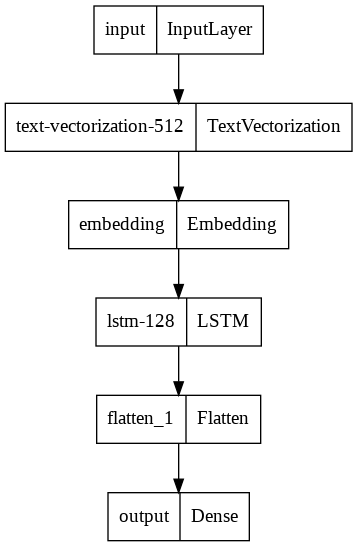

In [ ]:
tf.keras.utils.plot_model(rnn_model)

### Training

In [ ]:
from official.nlp import optimization  # to create AdamW optimizer

epochs = 15
batch_size = 64

train_size = (1 - VALIDATION_SPLIT) * train.size
steps_per_epoch = int(np.ceil(train_size / batch_size))
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

optimizer = optimization.create_optimizer(
    init_lr=5e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw"
)

rnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)

In [ ]:
# Stop training early if, after 5 epochs, validation loss doesn't decrease.
stop_early = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Save the best weights so far after each epoch.
rnn_checkpoint_path = "./drive/MyDrive/Checkpoints/rnn"
save_weights = tf.keras.callbacks.ModelCheckpoint(
    rnn_checkpoint_path,
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Plot the accuracy and loss live during training.
callbacks = [stop_early, save_weights, PlotLossesKeras()]

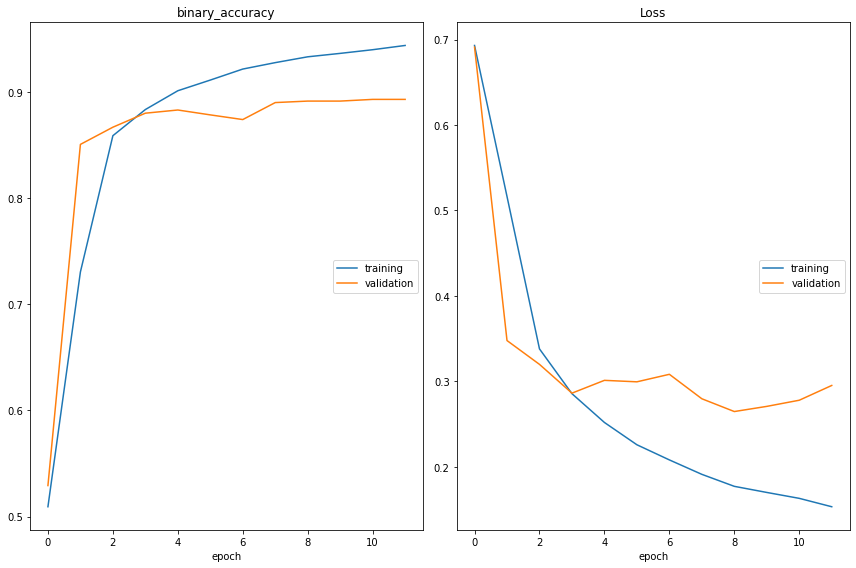

binary_accuracy
	training         	 (min:    0.509, max:    0.944, cur:    0.944)
	validation       	 (min:    0.529, max:    0.893, cur:    0.893)
Loss
	training         	 (min:    0.154, max:    0.693, cur:    0.154)
	validation       	 (min:    0.265, max:    0.691, cur:    0.295)
547/547 [==============================] - 1123s 2s/step - loss: 0.1535 - binary_accuracy: 0.9438 - val_loss: 0.2954 - val_binary_accuracy: 0.8930
Epoch 13/15
 51/547 [=>............................] - ETA: 16:41 - loss: 0.1283 - binary_accuracy: 0.9553

In [ ]:
rnn_model.fit(
    train,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks
)

### Testing

In [ ]:
rnn_model.evaluate(test, test_labels)

In [ ]:
output = rnn_model.predict(test)
output

In [ ]:
predictions = get_predictions(output)
predictions

In [ ]:
confusion_matrix = get_confusion_matrix(test_labels, predictions)
confusion_matrix

In [ ]:
predictions = get_predictions(output)
predictions

In [ ]:
confusion_matrix = get_confusion_matrix(test_labels, predictions)
confusion_matrix

In [ ]:
compute_metrics(confusion_matrix)

## Using Raw Text

### Setup

In [ ]:
train, test, train_labels, test_labels = train_test_split(
    reviews,
    labels
)

In [ ]:
training_vocabulary = generate_vocabulary(train)

In [ ]:
training_vocabulary

array(['original10', 'imagesthis', 'authoritiesthats', ..., 'presentis',
       'atrocious', 'faceanother'], dtype='<U74')

In [ ]:
rnn_raw_model = RNNClassifier(
    vocabulary=training_vocabulary,
    embedding_output_dim=128,
    lstm_units=128,
    dropout=0.5,
    recurrent_dropout=0.25
)

In [ ]:
rnn_raw_model.summary()

In [ ]:
tf.keras.utils.plot_model(rnn_raw_model)

### Training

In [ ]:
from official.nlp import optimization  # to create AdamW optimizer

epochs = 15
batch_size = 64

train_size = (1 - VALIDATION_SPLIT) * train.size
steps_per_epoch = int(np.ceil(train_size / batch_size))
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

optimizer = optimization.create_optimizer(
    init_lr=5e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw"
)

rnn_raw_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)

In [ ]:
# Stop training early if, after 5 epochs, validation loss doesn't decrease.
stop_early = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Save the best weights so far after each epoch.
rnn_checkpoint_path = "./drive/MyDrive/Checkpoints/rnn"
save_weights = tf.keras.callbacks.ModelCheckpoint(
    rnn_checkpoint_path,
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
# Plot the accuracy and loss live during training.
callbacks = [stop_early, save_weights, PlotLossesKeras()]

In [ ]:
rnn_raw_model.fit(
    train,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks
)

### Testing

In [ ]:
rnn_raw_model.evaluate(test, test_labels)

In [ ]:
output = rnn_raw_model.predict(test)
output

In [ ]:
predictions = get_predictions(output)
predictions

In [ ]:
confusion_matrix = get_confusion_matrix(test_labels, predictions)
confusion_matrix

In [ ]:
predictions = get_predictions(output)
predictions

In [ ]:
confusion_matrix = get_confusion_matrix(test_labels, predictions)
confusion_matrix

In [ ]:
compute_metrics(confusion_matrix)